In [3]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add("DotMaps")
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev")
@suppress Pkg.add(["Dates","Plots","DataFrames"])
@info "Dependencies added"

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/Documents/uni-4/FYP/fyp_repo/Project.toml`
  No Changes to `~/Documents/uni-4/FYP/fyp_repo/Manifest.toml`


┌ Info: Dependencies added
└ @ Main /Users/sherifagbabiaka/Documents/uni-4/FYP/fyp_repo/test.ipynb:6


In [23]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,125.07,130.9,124.17,130.28,112117500,2023-01-03T09:30:00,1672756200,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,126.36,128.66,125.08,126.89,89113600,2023-01-04T09:30:00,1672842600,NMS,America/New_York,USD,AAPL,NMS/AAPL
3,125.02,127.77,124.76,127.13,80962700,2023-01-05T09:30:00,1672929000,NMS,America/New_York,USD,AAPL,NMS/AAPL
4,129.62,130.29,124.89,126.01,87754700,2023-01-06T09:30:00,1673015400,NMS,America/New_York,USD,AAPL,NMS/AAPL
5,130.15,133.41,129.89,130.47,70790800,2023-01-09T09:30:00,1673274600,NMS,America/New_York,USD,AAPL,NMS/AAPL
6,130.73,131.26,128.12,130.26,63896200,2023-01-10T09:30:00,1673361000,NMS,America/New_York,USD,AAPL,NMS/AAPL
7,133.49,133.51,130.46,131.25,69458900,2023-01-11T09:30:00,1673447400,NMS,America/New_York,USD,AAPL,NMS/AAPL
8,133.41,134.26,131.44,133.88,71379600,2023-01-12T09:30:00,1673533800,NMS,America/New_York,USD,AAPL,NMS/AAPL
9,134.76,134.92,131.66,132.03,57809700,2023-01-13T09:30:00,1673620200,NMS,America/New_York,USD,AAPL,NMS/AAPL


In [26]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using DataFrames: DataFrame, groupby, combine, mean
#using AirBorne.Strategies.SMA: interday_initialize!, interday_trading_logic!
# include("./EMA.jl")
include("./MovingAverage.jl")
#using .EMA: interday_initialize!, interday_trading_logic!
using AirBorne.Structures: summarizePerformance,TimeEvent
using Dates
using DirectSearch
using PaddedViews

#  in a given amount of time, how many local optima can we find?
# consider using smoothing data optimisers
# noisy data optimisers - DirectSerarch -> compare with derivative based/noise sensitive

function weightings(prices, window)
    weights = [1,2,4,8,16]
    price_window = last(prices, length(weights))
    # price_window = PaddedView(0.0, price_window, window)
    # print(price_window)
    tmp = sum(weights .* price_window) / sum(weights)
    return sum(weights .* price_window) / sum(weights)
    #return mean(last(prices, window))
end
# try interpolation for custom weights -> structure may not be clear
function get_obj(time_data)
    function obj(x)
        avg_initialize!(context) = MovingAverage.interday_initialize!(context; 
            longHorizon=x[2], shortHorizon=x[1], initialCapital=10^4, averagingType=:exponential)
        avg_trading_logic! = MovingAverage.interday_trading_logic!
        # Run Simulation
        # max_iter = 100
    
        evalEvents = [
                TimeEvent(t, "data_transfer") for t in sort(unique(time_data.date); rev=true)
            ]
    
        @time context = run(
            time_data,
            avg_initialize!,
            avg_trading_logic!,
            execute_orders!,
            expose_data;
            audit=true,
            max_date=data[end, :date],
            verbose=false,
            initialEvents=evalEvents,
        )
    
        results = summarizePerformance(time_data, context)
        # print(results)
        return -results.dollarValue[end]
    end
    return obj
end

function event_func!(context)
    if context.extra.counter > 50
        curr_date = context.current_event.date
        # avail_dates =(data[!,:date] .<= curr_date) .&& (data[!,:date] .>= (curr_date-Dates.Day(100)))
        avail_dates = (curr_date-Dates.Day(50)) .<= data[!,:date] .<= curr_date
        optimise_data = data[avail_dates, :]
        p = DSProblem(2, objective=get_obj(optimise_data))
        SetInitialPoint(p, [1.0, 30.0])
        SetGranularity(p, [1, 1])
        slcond(x) = x[1] < x[2]
        valcond(x) = x[1] > 0 && x[2] > 0 && x[1] <= 100 && x[2] <= 100
        AddExtremeConstraint(p, slcond)
        AddExtremeConstraint(p, valcond)
        Optimize!(p)
        context.extra.long_horizon = p.x[2]
        context.extra.short_horizon = p.x[1]
        context.extra.counter = 0
    end
    context.extra.counter += 1
end 


function sma_init!(context)
    context.extra.counter = 0
    MovingAverage.interday_initialize!(context; 
        longHorizon=30, shortHorizon=10, initialCapital=10^4, averagingType=:exponential, nextEventFun=event_func!)
end 
my_trading_logic!(context, data; nextEventFun=nothing) = MovingAverage.interday_trading_logic!(context, data; nextEventFun=event_func!)
evaluationEvents = [
    TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
]
@time context = run(
    data,
    sma_init!,
    my_trading_logic!,
    execute_orders!,
    expose_data;
    audit=true,
    max_date=data[end, :date],
    verbose=false,
    initialEvents=evaluationEvents,
)

results = summarizePerformance(data, context)

# try fixing one var and optimising the other -> compute derivatives: if similar maybe a mixed integer LP
# JuMP.jl -> zygote.jl, reverse dif, forward dif
# Flux.jl -> auto dif
println("Done")
println("final dollar value: ", results.dollarValue[end])
# p = DSProblem(2, objective=obj)
# # x is a vector of length 2, containing the window sizes in the form (short, long)
# # obj(x) = sum(ema(data.close, x[1]) .- ema(data.close, x[2]))
# SetInitialPoint(p, [1.0, 100.0])
# SetGranularity(p, [1, 1])
# slcond(x) = x[1] < x[2]
# valcond(x) = x[1] > 0 && x[2] > 0 && x[1] <= 100 && x[2] <= 100
# AddExtremeConstraint(p, slcond)
# AddExtremeConstraint(p, valcond)
# Optimize!(p)

  0.134371 seconds (95.76 k allocations: 6.669 MiB, 89.74% compilation time)
  0.011393 seconds (25.64 k allocations: 1.973 MiB)
  0.012431 seconds (28.45 k allocations: 2.139 MiB)
  0.012530 seconds (29.51 k allocations: 2.199 MiB)
  0.013474 seconds (30.65 k allocations: 2.268 MiB)


  0.011581 seconds (22.40 k allocations: 1.791 MiB)
  0.020583 seconds (26.52 k allocations: 2.025 MiB)
  0.059308 seconds (24.12 k allocations: 1.885 MiB, 77.17% gc time)


  0.010731 seconds (24.89 k allocations: 1.932 MiB)
  0.019818 seconds (25.65 k allocations: 1.975 MiB)
  0.010680 seconds (26.50 k allocations: 2.023 MiB)
  0.012239 seconds (24.84 k allocations: 1.927 MiB)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [1.0, 32.0]
Feasible Cost               -10543.94213366621
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  52
Function Evaluations        12
Cache hits                  127
Optimization Status         Mesh Precision limit

Runtime                     0.5033559799194336
Search Time                 5.4250000000000006e-6
Poll Time                   0.0027624619999999985
Blackbox Evaluation Time    0.20357889999999965


  0.016436 seconds (27.44 k allocations: 2.077 MiB)
  0.014487 seconds (28.45 k allocations: 2.139 MiB)


  0.110638 seconds (29.55 k allocations: 2.203 MiB)
  0.022177 seconds (25.64 k allocations: 1.973 MiB)


  0.012992 seconds (22.40 k allocations: 1.791 MiB)
  0.015689 seconds (26.52 k allocations: 2.025 MiB)
  0.013783 seconds (24.12 k allocations: 1.885 MiB)
  0.014585 seconds (25.65 k allocations: 1.975 MiB)


  0.049195 seconds (26.55 k allocations: 2.027 MiB, 71.97% gc time)
  0.014888 seconds (24.84 k allocations: 1.927 MiB)
  0.016331 seconds (24.85 k allocations: 1.928 MiB)
MADS Run Summary
------------------------------------------------
Feasible Solution           [1.0, 32.0]
Feasible Cost               -10362.967259734045
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  52
Function Evaluations        11
Cache hits                  132
Optimization Status         Mesh Precision limit

Runtime                     0.32602882385253906
Search Time                 5.909e-6
Poll Time                   0.002870798
Blackbox Evaluation Time    0.3056161139999994


  0.013456 seconds (27.44 k allocations: 2.077 MiB)
  0.011216 seconds (25.64 k allocations: 1.973 MiB)
  0.011266 seconds (27.45 k allocations: 2.080 MiB)
  0.014537 seconds (29.51 k allocations: 2.199 MiB)


  0.053809 seconds (30.72 k allocations: 2.276 MiB, 66.54% gc time)
  0.009873 seconds (22.36 k allocations: 1.787 MiB)
  0.012924 seconds (30.65 k allocations: 2.268 MiB)
  0.008842 seconds (22.36 k allocations: 1.787 MiB)
  0.011192 seconds (25.65 k allocations: 1.975 MiB)


  0.010644 seconds (22.40 k allocations: 1.791 MiB)
  0.012431 seconds (24.85 k allocations: 1.928 MiB)
  0.009701 seconds (22.36 k allocations: 1.787 MiB)
  0.009248 seconds (22.36 k allocations: 1.787 MiB)
  0.010625 seconds (23.46 k allocations: 1.849 MiB)
  0.008648 seconds (22.36 k allocations: 1.787 MiB)
  0.011299 seconds (22.36 k allocations: 1.787 MiB)
  0.011157 seconds (24.84 k allocations: 1.927 MiB)
  0.009427 seconds (22.36 k allocations: 1.787 MiB)


  0.013264 seconds (23.51 k allocations: 1.854 MiB)
  0.015387 seconds (24.12 k allocations: 1.886 MiB)
  0.017376 seconds (23.46 k allocations: 1.848 MiB)
  0.015754 seconds (22.87 k allocations: 1.816 MiB)
  0.014160 seconds (24.12 k allocations: 1.885 MiB)
  0.013681 seconds (22.87 k allocations: 1.815 MiB)


  0.021327 seconds (22.92 k allocations: 1.820 MiB)


  0.106226 seconds (24.17 k allocations: 1.890 MiB)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [2.0, 35.0]
Feasible Cost               -10026.504959536502
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  56
Function Evaluations        26
Cache hits                  195
Optimization Status         Mesh Precision limit

Runtime                     0.4839339256286621
Search Time                 6.780999999999999e-6
Poll Time                   0.0038051180000000006
Blackbox Evaluation Time    0.46524558800000015


  0.018191 seconds (27.44 k allocations: 2.077 MiB)
  0.019616 seconds (29.51 k allocations: 2.199 MiB)
  0.013157 seconds (25.64 k allocations: 1.973 MiB)
  0.010968 seconds (27.45 k allocations: 2.080 MiB)
  0.010122 seconds (22.36 k allocations: 1.787 MiB)


  0.012995 seconds (28.50 k allocations: 2.143 MiB)
  0.009725 seconds (22.36 k allocations: 1.787 MiB)
  0.015617 seconds (30.67 k allocations: 2.272 MiB)
  0.010424 seconds (22.36 k allocations: 1.787 MiB)
  0.009924 seconds (22.36 k allocations: 1.787 MiB)
  0.016272 seconds (25.65 k allocations: 1.975 MiB)
  0.009153 seconds (22.36 k allocations: 1.787 MiB)
  0.010883 seconds (22.36 k allocations: 1.787 MiB)


  0.016138 seconds (23.50 k allocations: 1.853 MiB)
  0.020008 seconds (22.36 k allocations: 1.787 MiB)
  0.014476 seconds (22.36 k allocations: 1.787 MiB)
  0.018477 seconds (22.87 k allocations: 1.816 MiB)
  0.018588 seconds (27.45 k allocations: 2.080 MiB)
  0.009410 seconds (22.87 k allocations: 1.816 MiB)


  0.011277 seconds (24.89 k allocations: 1.931 MiB)
  0.010341 seconds (24.12 k allocations: 1.886 MiB)
  0.012080 seconds (24.12 k allocations: 1.886 MiB)
  0.010220 seconds (23.46 k allocations: 1.849 MiB)
  0.041214 seconds (24.85 k allocations: 1.928 MiB, 64.75% gc time)
  0.011885 seconds (24.12 k allocations: 1.886 MiB)


  0.010920 seconds (24.89 k allocations: 1.933 MiB)
  0.012773 seconds (24.12 k allocations: 1.885 MiB)
  0.012150 seconds (23.46 k allocations: 1.849 MiB)
MADS Run Summary
------------------------------------------------
Feasible Solution           [2.0, 34.0]
Feasible Cost               -10148.031052898385
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  58
Function Evaluations        28
Cache hits                  195
Optimization Status         Mesh Precision limit

Runtime                     0.45420312881469727
Search Time                 9.368999999999994e-6
Poll Time                   0.004861497
Blackbox Evaluation Time    0.42927769299999974


  4.166734 seconds (4.83 M allocations: 341.768 MiB, 20.96% gc time, 48.94% compilation time: 25% of which was recompilation)
Done
final dollar value: 12574.619424714454


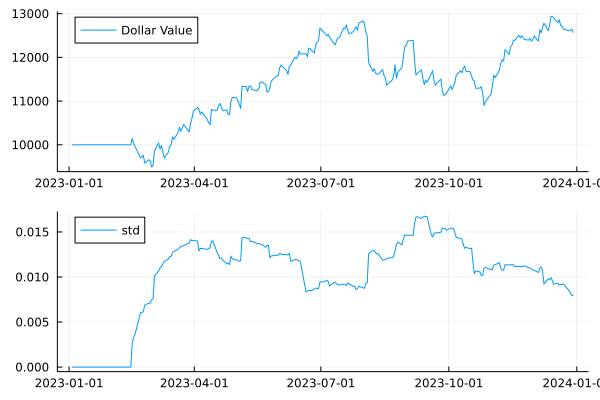

In [27]:
using Plots: plot, plot!
results = summarizePerformance(data, context, windowSize=30)

val = plot(results.date, results.dollarValue, label="Dollar Value")
std = plot(results.date, results.std_return, label="std")
plot(val, std, layout=(2,1), legend=:topleft)

In [13]:
avg_initialize!(context) = MovingAverage.interday_initialize!(context; 
        longHorizon=p.x[2], shortHorizon=p.x[1], initialCapital=10^4, averagingType=:simple)
avg_trading_logic! = MovingAverage.interday_trading_logic!
# Run Simulation
# max_iter = 100

evaluationEvents = [
        TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
    ]

@time context = run(
    data,
    avg_initialize!,
    avg_trading_logic!,
    execute_orders!,
    expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=false,
    initialEvents=evaluationEvents,
)

results = summarizePerformance(data, context)

  2.842097 seconds (5.88 M allocations: 693.338 MiB, 29.66% gc time, 19.52% compilation time: 4% of which was recompilation)


Row,date,type,portfolio,account,stockValue,dollarValue,return,mean_return,std_return,sharpe
,DateTime,String,Any,Any,Dict…?,Real,Union…,Union…,Union…,Union…
1,2017-01-03T09:30:00,start,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.307, ""NMS/AAPL""=>29.0375)",10000,0.0,0.0,NaN,
2,2017-01-03T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.307, ""NMS/AAPL""=>29.0375)",10000,0.0,0.0,0.0,
3,2017-01-04T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.345, ""NMS/AAPL""=>29.005)",10000,0.0,0.0,0.0,
4,2017-01-05T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.701, ""NMS/AAPL""=>29.1525)",10000,0.0,0.0,0.0,
5,2017-01-06T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.3075, ""NMS/AAPL""=>29.4775)",10000,0.0,0.0,0.0,
6,2017-01-09T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.3325, ""NMS/AAPL""=>29.7475)",10000,0.0,0.0,0.0,
7,2017-01-10T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.2395, ""NMS/AAPL""=>29.7775)",10000,0.0,0.0,0.0,
8,2017-01-11T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.3955, ""NMS/AAPL""=>29.9375)",10000,0.0,0.0,0.0,
9,2017-01-12T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.318, ""NMS/AAPL""=>29.8125)",10000,0.0,0.0,0.0,


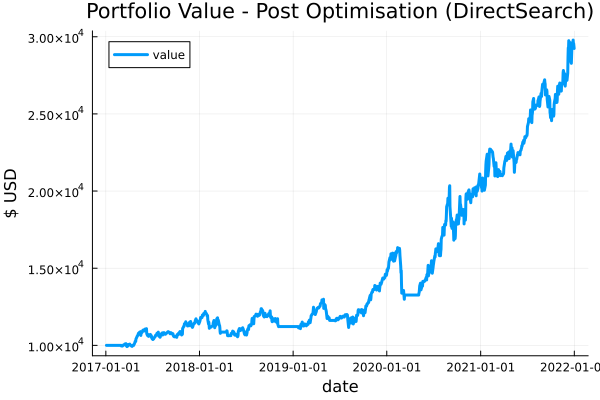

In [16]:



using Plots: plot, plot!
plot(results.date, results.dollarValue, title="Portfolio Value - Post Optimisation (DirectSearch)", label="value", linewidth=3, xlabel="date",ylabel="\$ USD")